## Постановка задачи
Разберем архитектуру LeNet и AlexNet для решения задач распознавания изображений. Применим их для анализа исходных изображений.

Обучим модели, используя последовательную загрузку данных. Проведем оценку качества предсказания по коэффициенту сходства.

Данные:
* https://video.ittensive.com/machine-learning/clouds/train.csv.gz (54 Мб)
* https://video.ittensive.com/machine-learning/clouds/train_images_small.tar.gz (212 Мб)

Соревнование: https://www.kaggle.com/c/understanding_cloud_organization/

© ITtensive, 2020

### Подключение библиотек

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from skimage import io
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization, ZeroPadding2D
from keras import optimizers
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Using TensorFlow backend.


### Используемые функции

In [2]:
filesDir = "train_images_small"
batch_size = 20
image_x = 525 # 525
image_y = 350 # 350
image_ch = 3 # 3
def mask_rate (a, x, y):
    b = a//1400 + 0.0
    return np.round(x*(b*x//2100) + y*(a%1400)//1400).astype("uint32")

def calc_mask (px, x=image_x, y=image_y):
    p = np.array([int(n) for n in px.split(' ')]).reshape(-1,2)
    mask = np.zeros(x*y, dtype='uint8')
    for i, l in p:
        mask[mask_rate(i, x, y) - 1:mask_rate(l+i, x, y)] = 1
    return mask.reshape(y,x).transpose()

def calc_dice (x):
    dice = 0
    px = x["EncodedPixels"] 
    if px != px and x["target"] == 0:
        dice = 1
    elif px == px and x["target"] == 1:
        mask = calc_mask(px).flatten()
        target = np.ones(image_x*image_y, dtype='uint8')
        dice += 2*np.sum(target[mask==1])/(np.sum(target)+np.sum(mask))
    return dice

def load_y (df):
    return np.array(df["EncodedPixels"].notnull().astype("int8")).reshape(len(df), 1)

def load_x (df):
    x = [[]]*len(df)
    for j, file in enumerate(df["Image"]):
        x[j] = io.imread(os.path.join(filesDir, file))
    return np.array(x).reshape(len(df), image_y, image_x, image_ch)

def load_data (df, batch_size):
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < len(df):
            limit = min(batch_end, len(df))
            yield (load_x(df[batch_start:limit]),
                   load_y(df[batch_start:limit]))
            batch_start += batch_size   
            batch_end += batch_size

### Загрузка данных

In [3]:
data = pd.read_csv('https://video.ittensive.com/machine-learning/clouds/train.csv.gz')

In [4]:
data["Image"] = data["Image_Label"].str.split("_").str[0]
data["Label"] = data["Image_Label"].str.split("_").str[1]
data.drop(labels=["Image_Label"], axis=1, inplace=True)
data_fish = data[data["Label"] == "Fish"]
print (data_fish.head())

                                        EncodedPixels        Image Label
0   264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg  Fish
4   233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg  Fish
8   3510 690 4910 690 6310 690 7710 690 9110 690 1...  0031ae9.jpg  Fish
12                                                NaN  0035239.jpg  Fish
16  2367966 18 2367985 2 2367993 8 2368002 62 2369...  003994e.jpg  Fish


### Разделение данных
Разделим всю выборку на 2 части случайным образом: 80% - для обучения модели, 20% - для проверки точности модели.

In [5]:
train, test = train_test_split(data_fish, test_size=0.2)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
del data
print (train.head())

                                           EncodedPixels        Image Label
4588                                                 NaN  3509cbc.jpg  Fish
6900   1250336 847 1251736 847 1253136 847 1254536 84...  4f4b396.jpg  Fish
7584   1162967 433 1164367 433 1165767 433 1167167 43...  567d89b.jpg  Fish
10060  1524601 714 1526001 714 1527401 714 1528801 71...  729e50e.jpg  Fish
7988   305201 1189 306601 1189 308001 1189 309401 118...  5b291dc.jpg  Fish


### LeNet5
Первая успешная архитектура сверточной нейросети, 1998
![](lenet.png)

In [6]:
lenet = Sequential([
    Conv2D(6, (5,5), input_shape=(image_y, image_x, image_ch),
          kernel_initializer="glorot_uniform", strides=(1,1)),
    Activation("relu"),
    AveragePooling2D(pool_size=(2,2)),
    Conv2D(16, (5,5),
          kernel_initializer="glorot_uniform", strides=(1,1)),
    Activation("relu"),
    AveragePooling2D(pool_size=(2,2)),
    Flatten(),
    Activation("tanh"),
    Dense(120),
    Activation("tanh"),
    Dense(84),
    Activation("softmax"),
    Dense(1)
])

W0317 10:37:34.046737  1788 deprecation_wrapper.py:119] From c:\users\nikolay\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



### Обучение модели
Обучим построенную модель и вычислим ее точность, используя самый лучший разделитель значений

In [10]:
def train_evaluate_model (model):
    model.compile(optimizer=optimizers.Nadam(lr=0.05),
                 loss="mean_absolute_error")
    model.fit_generator(load_data(train, batch_size),
            epochs=50, steps_per_epoch=len(train)//batch_size)
    prediction = model.predict_generator(load_data(test, 1),
            steps=len(test), verbose=1)
    prediction = np.transpose(prediction)
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(1,1,1)
    ax.hist(prediction[0])
    ax.set_title("Fish")
    plt.show()
    acc = prediction[0].mean()
    acc_max = prediction[0].max()
    if acc == acc_max:
        test["target"] = np.round(prediction[0])
        return test.apply(calc_dice, axis=1,
                          result_type="expand").mean()
    else:
        dice_best = 0
        for i in range(0,20):
            acc += (acc_max - acc)*i/20
            test["target"] = (prediction[0] >= acc).astype("int8")
            dice = test.apply(calc_dice, axis=1, result_type="expand")
            if dice_best < dice.mean():
                dice_best = dice.mean()
            else:
                break
        return dice_best

Epoch 1/50
221/221 [==============================] - 863s 4s/step - loss: 0.4976
Epoch 2/50
221/221 [==============================] - 901s 4s/step - loss: 0.4968
Epoch 3/50
221/221 [==============================] - 882s 4s/step - loss: 0.4964
Epoch 4/50
221/221 [==============================] - 828s 4s/step - loss: 0.4968
Epoch 5/50
221/221 [==============================] - 797s 4s/step - loss: 0.4978
Epoch 6/50
221/221 [==============================] - 808s 4s/step - loss: 0.4972
Epoch 7/50
221/221 [==============================] - 791s 4s/step - loss: 0.4967
Epoch 8/50
221/221 [==============================] - 852s 4s/step - loss: 0.4971
Epoch 9/50
221/221 [==============================] - 949s 4s/step - loss: 0.4966
Epoch 10/50
221/221 [==============================] - 1177s 5s/step - loss: 0.4973
Epoch 11/50
221/221 [==============================] - 799s 4s/step - loss: 0.4964
Epoch 12/50
221/221 [==============================] - 799s 4s/step - loss: 0.4970
Epoch 13/50


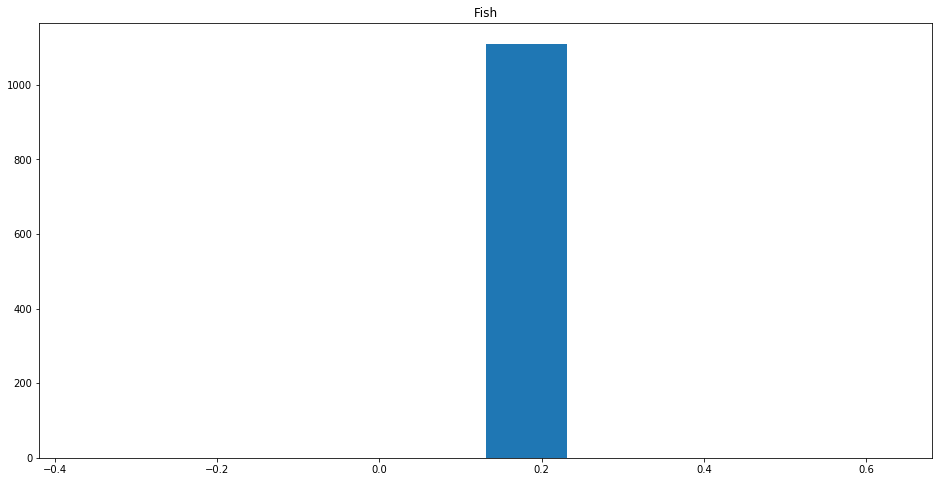

Keras, LeNet: 0.513


In [11]:
print ("Keras, LeNet:", round(train_evaluate_model(lenet), 3))

In [12]:
del lenet

### AlexNet и CaffeNet
Первая сверточная нейросеть, победившая в ImageNet
![](alexnet.webp)
CaffeNet - однопроцессорная версия AlexNet

Для реализации потребуется задать шаг свертки (strides) и дополнительные слои для заполнения границ изображения нулями, чтобы не уменьшать область после свертки.

In [15]:
alexnet = Sequential([
    Conv2D(96, (11,11), input_shape=(image_y, image_x, image_ch),
          kernel_initializer='glorot_uniform', strides=(4,4)),
    Activation("relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    ZeroPadding2D(padding=(2,2)),
    Conv2D(256, (5,5), kernel_initializer='glorot_uniform'),
    Activation("relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    ZeroPadding2D(padding=(1,1)),
    Conv2D(384, (3,3), kernel_initializer='glorot_uniform'),
    Activation("relu"),
    BatchNormalization(),
    ZeroPadding2D(padding=(1,1)),
    Conv2D(384, (3,3), kernel_initializer='glorot_uniform'),
    Activation("relu"),
    BatchNormalization(),
    ZeroPadding2D(padding=(1,1)),
    Conv2D(256, (3,3), kernel_initializer='glorot_uniform'),
    Activation("relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Activation("relu"),
    Dense(1024),
    Activation("relu"),
    Dense(1024),
    Activation("softmax"),
    Dense(1)
])

Epoch 1/50
221/221 [==============================] - 3937s 18s/step - loss: 0.5009
Epoch 2/50
221/221 [==============================] - 4251s 19s/step - loss: 0.4972
Epoch 3/50
221/221 [==============================] - 4218s 19s/step - loss: 0.4968
Epoch 4/50
221/221 [==============================] - 5887s 27s/step - loss: 0.4966
Epoch 5/50
221/221 [==============================] - 6410s 29s/step - loss: 0.4979
Epoch 6/50
221/221 [==============================] - 9919s 45s/step - loss: 0.4984
Epoch 7/50
221/221 [==============================] - 4279s 19s/step - loss: 0.4969
Epoch 8/50
221/221 [==============================] - 15050s 68s/step - loss: 0.4970
Epoch 9/50
221/221 [==============================] - 6435s 29s/step - loss: 0.4958
Epoch 10/50
221/221 [==============================] - 4118s 19s/step - loss: 0.4970
Epoch 11/50
221/221 [==============================] - 4070s 18s/step - loss: 0.4969
Epoch 12/50
221/221 [==============================] - 4292s 19s/step - l

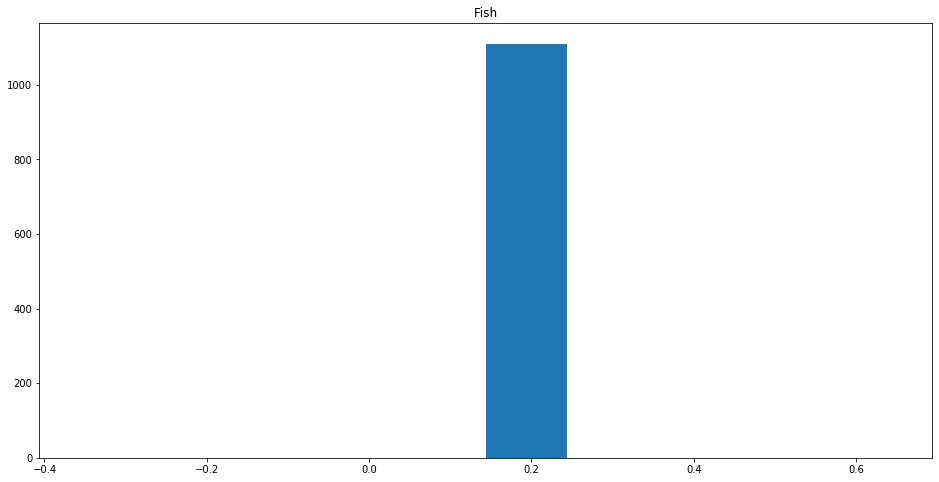

Keras, AlexNet: 0.167


In [16]:
print ("Keras, AlexNet:", round(train_evaluate_model(alexnet), 3))